# Transport equation 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

$u_t + c u_x = 0$ with initial condition $u(0,x)= g(x)= e^{-x^2}$.

The analytical solution is given by $u(t,x) = g(x-ct)$.

## Libraries

In [1]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [2]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [3]:
def Kphiphi_assembly(Xomega, Xboundary , h, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param)
  val2 = K_dot(kernel, Xomega, Xomega, k_param, 0)
  val3 = K_dot(kernel, Xomega, Xomega, k_param, 1)
  # val3 = val2
  val4 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 1)
  val = val1 + h*c*val2 + h*c*(val3 + h*c*val4)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val2 = K_dot(kernel, Xomega, Xboundary, k_param, 0)
  val = val1 + h*c*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [4]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = K_dot(kernel, Xomega, Xtest, k_param, 0)
  val = val1 + h*c*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [5]:
# X_full
Xfull = np.linspace(-5,5,102)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = transport_u0(Xomega)
# kparam
k_param = 0.5
# Wave speed
c = 1
# Time step
h = 0.01

Build `Kphiphi`

In [6]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)

Build `y_prev`

In [7]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [8]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

Get `K(Xtest,Xfull)`

In [9]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

In [10]:
u_next = np.dot(Kphi.T,sol)

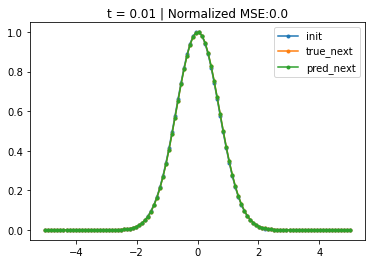

In [11]:
# Initial condition
plt.plot(Xfull,transport_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,transport_sol(Xfull,h,c),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,transport_sol(Xfull,h,c))/mean_squared_error(0*transport_sol(Xfull,h,c),transport_sol(Xfull,h,c))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

$u_{next} = K(X_{test}, \phi) K(\phi,\phi)^{-1}u_{prev}$

In [12]:
t = 1
steps = int(t//h)
# Initialize at the initial condition
# do the time step ! 
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

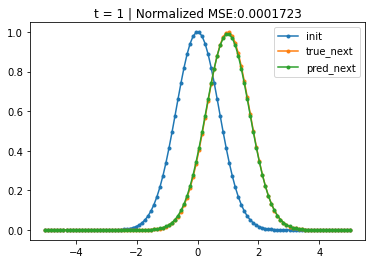

In [13]:
# Numerical vs. Analytical
# Initial condition
plt.plot(Xfull,transport_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,transport_sol(Xfull,t,c),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,transport_sol(Xfull,t,c))/mean_squared_error(0*transport_sol(Xfull,t,c),transport_sol(Xfull,t,c))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

### Experiment 1

- $h = $ `1e-1`.
- $t = 1$.
- Collocation points increasing from $2^{2}$ to $2^{10}$

In [14]:
# Experiment 1- L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = transport_u0(Xomega)
    # Kernel parameter
    k_param = 0.5
    # Wave speed
    c = 1
    # Time step
    h = 1e-1
    # Final t
    t = 1
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = transport_sol(Xfull , t, c)
    # Difference
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.1010305124405506
0.4871229008395357
0.13839197048014745
0.13723950610871258
0.13723905643071788
0.13723882636665616
0.1372387099930649
0.13723865146669076


- $h = $ `1e-2`.
- $t = 1$.
- Collocation points increasing from $2^{2}$ to $2^{10}$

In [15]:
# Experiment 1- L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = transport_u0(Xomega)
    # Kernel parameter
    k_param = 0.5
    # Wave speed
    c = 1
    # Time step
    h = 1e-2
    # Final t
    t = 1
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = transport_sol(Xfull , t, c)
    # Difference
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.0282797689074177
0.477061473143753
0.017092849086006234
0.014704422995547008
0.01469704240845617
0.014693271154667462
0.014691364770808214
0.014690406323261983


- $h = $ `1e-3`.
- $t = 1$.
- Collocation points increasing from $2^{2}$ to $2^{10}$

In [16]:
# Experiment 3- L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = transport_u0(Xomega)
    # Kernel parameter
    k_param = 0.5
    # Wave speed
    c = 1
    # Time step
    h = 1e-3
    # Final t
    t = 1
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = transport_sol(Xfull , t, c)
    # Difference
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.020963438335367
0.4816972616890579
0.007425080499941869
0.0016602773998011628
0.0015657955751418318
0.0015215396451264927
0.0015003165567826666
0.0014899531963680078


- $h = $ `1e-4`.
- $t = 1$.
- Collocation points increasing from $2^{2}$ to $2^{10}$

In [17]:
# Experiment 4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = transport_u0(Xomega)
    # Kernel parameter
    k_param = 0.5
    # Wave speed
    c = 1
    # Time step
    h = 1e-4
    # Final t
    t = 1
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = transport_sol(Xfull , t, c)
    # Difference
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.0220887394358933
0.48020061936641534
0.009346024579962664
0.003287759722951293
0.0017097985520716113
0.0009046256232992642
0.0005024733994227156
0.0003078455006262692


In [18]:
# Experiment 5 - L2-norms
L2_norms_5 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = transport_u0(Xomega)
    # Kernel parameter
    k_param = 0.5
    # Wave speed
    c = 1
    # Time step
    h = 1e-5
    # Final t
    t = 1
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = transport_sol(Xfull , t, c)
    # Difference
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.0416882506237413
0.46898007237372485
0.060754876757376085
0.03165925228268603
0.016209348400986513
0.008205851808546325
0.004131418834895782
0.002075637260895989


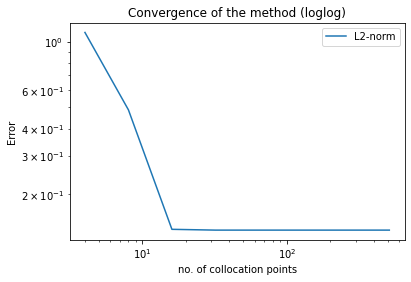

In [19]:
# Experiment 1 - Convergence plot
plt.loglog(xrange,L2_norms_1,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

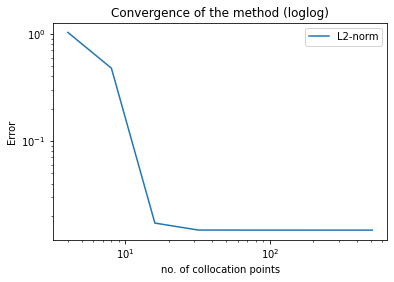

In [20]:
# Experiment 2 - Convergence plot
plt.loglog(xrange,L2_norms_2,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

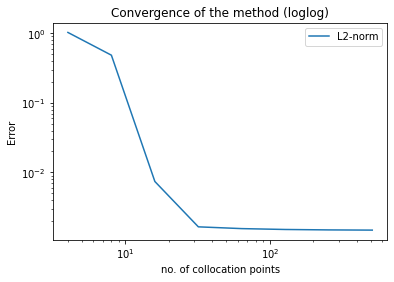

In [21]:
# Experiment 3 - Convergence plot
plt.loglog(xrange,L2_norms_3,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

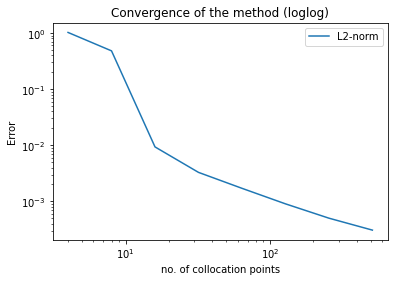

In [22]:
# Experiment 4 - Convergence plot
plt.loglog(xrange,L2_norms_4,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

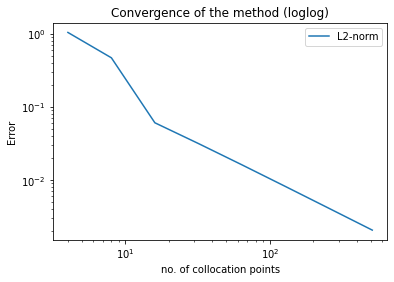

In [23]:
# Experiment 5 - Convergence plot
plt.loglog(xrange,L2_norms_5,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

Text(0.5, 1.0, '$h = 1e-5$')

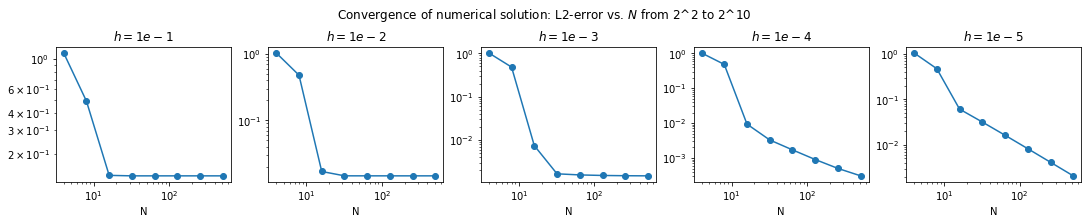

In [48]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $N$ from 2^2 to 2^10')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('N')
axs[0].set_title('$h = 1e-1$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('N')
axs[1].set_title('$h = 1e-2$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('N')
axs[2].set_title('$h = 1e-3$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('N')
axs[3].set_title('$h = 1e-4$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('N')
axs[4].set_title('$h = 1e-5$')

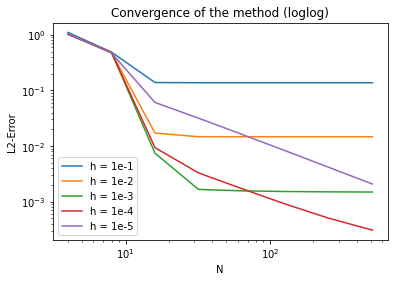

In [49]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4')
plt.loglog(xrange,L2_norms_5,label = 'h = 1e-5')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()